In [1]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
import pandas as pd
from ekfplot import plot as ek, colors as ec
from ekfstats import math, fit, imstats

from pieridae.starbursts import sample

In [2]:
import torch
import torch.nn as nn
from byol_pytorch import BYOL
from torchvision import models

In [3]:
from tqdm import tqdm
from ekfstats import functions

In [13]:
filenames = glob.glob('../local_data/pieridae_output/starlet/starbursts_v0/M*/*i_results.pkl')

imgs = []
img_names = []
for fname in filenames:
    img = []
    for band in 'gi':
        current_filename = fname.replace('_i_',f'_{band}_')

        
        with open(current_filename,'rb') as f:
            xf = pickle.load(f)

            img.append(xf['image'])
            if band == 'i':
                img.append(xf['hf_image'])

    
    imgs.append(np.array(img))
    img_names.append(fname.split('/')[-2])
imgs = np.array(imgs)
img_names = np.array(img_names)

(<matplotlib.image.AxesImage at 0x17fd00550>, <Axes: >)

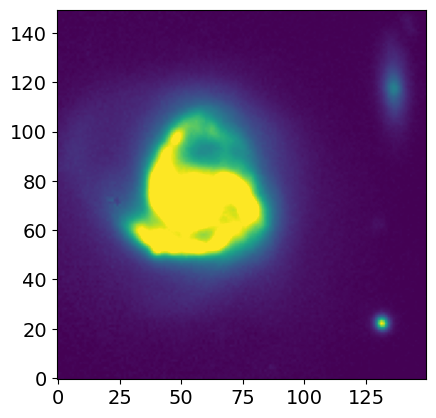

In [24]:
sidx = 8
ek.imshow(imgs[sidx,1],  q=0.05)

In [5]:
def sample_unlabelled_images():
    indices = np.random.permutation(len(imgs))
    return torch.tensor(imgs[indices], dtype=torch.float32)

In [6]:
# Using torchvision transforms (wrapped in nn.Sequential)
transform1 = nn.Sequential(
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=180),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
)

transform2 = nn.Sequential(
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=180),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3)
)

resnet = models.resnet18(pretrained=True)

learner = BYOL(
    resnet,
    image_size=150,
    hidden_layer='avgpool',
    projection_size=256,        # Final projection dimension
    projection_hidden_size=1024, # Hidden layer in projector MLP
    moving_average_decay=0.99,   # τ_base for shorter training
    use_momentum=True,
    augment_fn=transform1,
    augment_fn2=transform2
)

/home/kadofong/.conda/envs/merenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kadofong/.conda/envs/merenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
opt = torch.optim.Adam(learner.parameters(), lr=3e-4)

for _ in tqdm(range(50)):
    images = sample_unlabelled_images()
    loss = learner(images)
    opt.zero_grad()
    loss.backward()
    opt.step()
    learner.update_moving_average() # update moving average of target encoder

100%|██████████| 50/50 [30:04<00:00, 36.09s/it]


In [8]:
projection, embedding = learner(torch.tensor(imgs, dtype=torch.float32), return_embedding = True)

In [9]:
from astropy.visualization import make_lupton_rgb

In [10]:
# Example: Find similar images using embeddings
from sklearn.metrics.pairwise import cosine_similarity

# Get embeddings for multiple images
embeddings = embedding.detach().numpy()

# Compute similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Find most similar image to the first one
#pairs = np.zeros([len(embeddings),2])
#for sidx in range(len(embeddings)):    
sidx = 448#np.where(img_names=='M3406229848245433130')[0][0]
most_similar_idx = similarity_matrix[sidx].argsort()[-2]  # -1 would be itself
#pairs[sidx] = [sidx,most_similar_idx]
print(f"Most similar image to image {sidx}: image {most_similar_idx}")

Most similar image to image 448: image 2534


(<matplotlib.image.AxesImage at 0x1468b43b6b90>, <Axes: >)

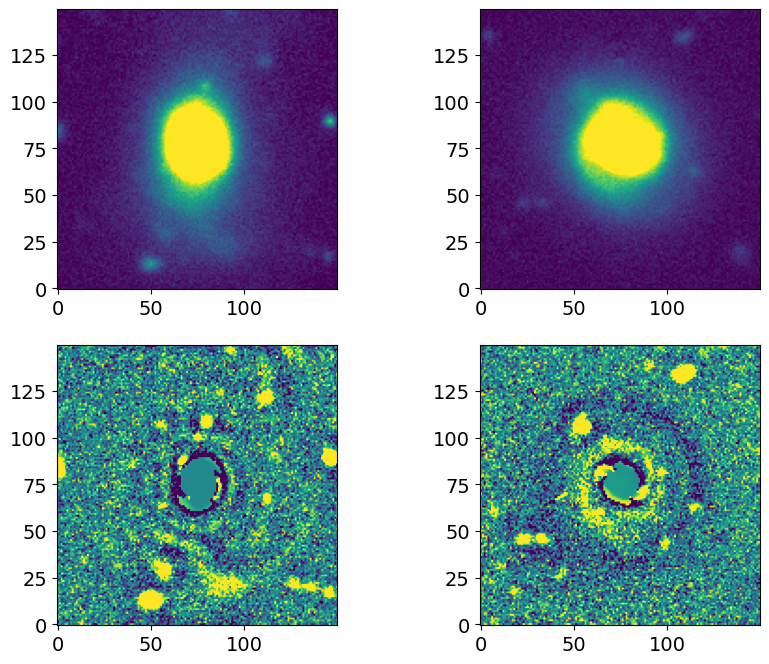

In [11]:
fig,axarr = plt.subplots(2,2,figsize=(10,8))

ek.imshow(imgs[sidx,0],ax=axarr[0,0],  q=0.05)
ek.imshow(imgs[most_similar_idx,0],ax=axarr[0,1], q=0.05)
ek.imshow(imgs[sidx,2],ax=axarr[1,0],  q=0.05)
ek.imshow(imgs[most_similar_idx,2],ax=axarr[1,1], q=0.05)

In [12]:
import umap

In [13]:
mergers = pd.read_csv('./classifications_kadofong_20250925.csv', index_col=0)
# 1 undisturbed
# 2 ambiguous
# 3 merger
# 4 fragmentation
# 5 artifact

In [14]:
labels = mergers.reindex(img_names)
labels = labels.replace(np.nan, 0).values.flatten()

#cmap = ec.colormap_from_list(['lightgrey','C0','pink','r','tab:green','C4', 'k'], 'discrete')
cmap_1 = ec.colormap_from_list(['lightgrey','C0','tab:orange','r','tab:green','C4','k'], 'discrete')

names = {1:'undisturbed',2:'ambiguous',3:'merger',4:'fragmentation',5:'artifact'}

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def create_embeddings_pca_umap(learner, images, 
                              # PCA parameters
                              pca_components=None, explained_variance_threshold=0.95,
                              standardize=True, 
                              # UMAP parameters
                              n_components=2, n_neighbors=15, min_dist=0.1, 
                              metric='euclidean', random_state=42):
    """
    Extract embeddings from BYOL model, apply PCA for dimensionality reduction,
    then apply UMAP for visualization and clustering.
    
    Args:
        learner: Trained BYOL model
        images: Input images tensor (batch_size, channels, height, width)
        
        # PCA parameters
        pca_components: Number of PCA components to keep. If None, uses explained_variance_threshold
        explained_variance_threshold: Keep components that explain this much variance (0.0-1.0)
        standardize: Whether to standardize features before PCA
        
        # UMAP parameters  
        n_components: Final number of dimensions (2 or 3 for visualization)
        n_neighbors: UMAP parameter controlling local vs global structure (5-50)
        min_dist: UMAP parameter controlling cluster tightness (0.001-0.5)
        metric: Distance metric for UMAP ('euclidean', 'cosine', 'manhattan')
        random_state: Random seed for reproducibility
    
    Returns:
        dict: Contains all fitted models and embeddings
            - 'scaler': Fitted StandardScaler (if used)
            - 'pca': Fitted PCA model
            - 'umap': Fitted UMAP model
            - 'embeddings_original': Original BYOL embeddings
            - 'embeddings_pca': PCA-reduced embeddings
            - 'embeddings_umap': Final UMAP embeddings
            - 'pca_info': Dictionary with PCA analysis information
    
    Example:
        >>> result = create_embeddings_pca_umap(learner, imgs_tensor, 
                                               pca_components=50, n_components=2)
        >>> print(f"Original shape: {result['embeddings_original'].shape}")
        >>> print(f"PCA shape: {result['embeddings_pca'].shape}")  
        >>> print(f"UMAP shape: {result['embeddings_umap'].shape}")
    """
    
    # Extract embeddings from BYOL model
    print("Extracting BYOL embeddings...")
    learner.eval()
    with torch.no_grad():
        _, embeddings = learner(images, return_embedding=True)
    
    # Convert to numpy and clean data
    embeddings_np = embeddings.cpu().numpy().astype(np.float32)
    embeddings_np = np.nan_to_num(embeddings_np, nan=0.0, posinf=0.0, neginf=0.0)
    
    print(f"Original BYOL embeddings shape: {embeddings_np.shape}")
    
    # Step 1: Standardization (optional but recommended)
    scaler = None
    if standardize:
        print("Standardizing features...")
        scaler = StandardScaler()
        embeddings_standardized = scaler.fit_transform(embeddings_np)
    else:
        embeddings_standardized = embeddings_np
    
    # Step 2: PCA Analysis and Reduction
    print("Applying PCA...")
    
    # Determine number of PCA components
    if pca_components is None:
        # Use explained variance threshold to determine components
        pca_full = PCA()
        pca_full.fit(embeddings_standardized)
        cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
        pca_components = np.argmax(cumsum_var >= explained_variance_threshold) + 1
        print(f"Using {pca_components} PCA components to explain {explained_variance_threshold:.1%} variance")
    
    # Ensure we don't use more components than available
    max_components = min(embeddings_standardized.shape[0] - 1, embeddings_standardized.shape[1])
    pca_components = min(pca_components, max_components)
    
    # Fit PCA with determined number of components
    pca = PCA(n_components=pca_components, random_state=random_state)
    embeddings_pca = pca.fit_transform(embeddings_standardized)
    
    # PCA analysis information
    pca_info = {
        'n_components': pca_components,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_explained_variance': np.cumsum(pca.explained_variance_ratio_),
        'total_explained_variance': np.sum(pca.explained_variance_ratio_),
        'singular_values': pca.singular_values_
    }
    
    print(f"PCA reduced embeddings shape: {embeddings_pca.shape}")
    print(f"Total explained variance: {pca_info['total_explained_variance']:.3f}")
    
    # Step 3: UMAP on PCA-reduced embeddings
    print("Applying UMAP to PCA features...")
    
    # Adjust n_neighbors for PCA-reduced data
    n_neighbors = min(n_neighbors, len(embeddings_pca) - 1)
    
    # For PCA-reduced features, euclidean distance is often more appropriate
    umap_reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        verbose=False
    )
    
    embeddings_umap = umap_reducer.fit_transform(embeddings_pca)
    
    print(f"Final UMAP embeddings shape: {embeddings_umap.shape}")
    
    # Return comprehensive results
    return {
        'scaler': scaler,
        'pca': pca,
        'umap': umap_reducer,
        'embeddings_original': embeddings_np,
        'embeddings_pca': embeddings_pca,
        'embeddings_umap': embeddings_umap,
        'pca_info': pca_info
    }


def analyze_pca_components(pca_info, n_top_components=10, figsize=(12, 8)):
    """
    Analyze and visualize PCA component information.
    
    Args:
        pca_info: Dictionary containing PCA analysis from create_embeddings_pca_umap
        n_top_components: Number of top components to show in detail
        figsize: Figure size for plots
    
    Returns:
        matplotlib figure object
    """
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('PCA Analysis of BYOL Embeddings', fontsize=16)
    
    # Plot 1: Explained variance ratio
    axes[0,0].bar(range(1, min(n_top_components + 1, len(pca_info['explained_variance_ratio']) + 1)), 
                  pca_info['explained_variance_ratio'][:n_top_components])
    axes[0,0].set_xlabel('Principal Component')
    axes[0,0].set_ylabel('Explained Variance Ratio')
    axes[0,0].set_title('Individual Component Variance')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Cumulative explained variance
    axes[0,1].plot(range(1, len(pca_info['cumulative_explained_variance']) + 1), 
                   pca_info['cumulative_explained_variance'], 'bo-')
    axes[0,1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
    axes[0,1].axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
    axes[0,1].set_xlabel('Number of Components')
    axes[0,1].set_ylabel('Cumulative Explained Variance')
    axes[0,1].set_title('Cumulative Variance Explained')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].legend()
    
    # Plot 3: Scree plot (singular values)
    axes[1,0].plot(range(1, min(n_top_components + 1, len(pca_info['singular_values']) + 1)), 
                   pca_info['singular_values'][:n_top_components], 'go-')
    axes[1,0].set_xlabel('Principal Component')
    axes[1,0].set_ylabel('Singular Value')
    axes[1,0].set_title('Scree Plot')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Component importance summary
    top_5_variance = pca_info['explained_variance_ratio'][:5]
    axes[1,1].pie(list(top_5_variance) + [1 - sum(top_5_variance)], 
                  labels=[f'PC{i+1}' for i in range(5)] + ['Others'], 
                  autopct='%1.1f%%')
    axes[1,1].set_title('Top 5 Components Contribution')
    
    plt.tight_layout()
    return fig


def transform_new_data(result_dict, new_images, learner):
    """
    Transform new images using the fitted PCA and UMAP models.
    
    Args:
        result_dict: Dictionary returned from create_embeddings_pca_umap
        new_images: New images to transform
        learner: BYOL model (same as used for fitting)
    
    Returns:
        dict: Transformed embeddings at each stage
    """
    
    # Extract new embeddings
    learner.eval()
    with torch.no_grad():
        _, new_embeddings = learner(new_images, return_embedding=True)
    
    new_embeddings_np = new_embeddings.cpu().numpy().astype(np.float32)
    new_embeddings_np = np.nan_to_num(new_embeddings_np, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Apply same transformations
    if result_dict['scaler'] is not None:
        new_embeddings_scaled = result_dict['scaler'].transform(new_embeddings_np)
    else:
        new_embeddings_scaled = new_embeddings_np
    
    new_embeddings_pca = result_dict['pca'].transform(new_embeddings_scaled)
    new_embeddings_umap = result_dict['umap'].transform(new_embeddings_pca)
    
    return {
        'embeddings_original': new_embeddings_np,
        'embeddings_pca': new_embeddings_pca,
        'embeddings_umap': new_embeddings_umap
    }


def visualize_embeddings_comparison(result_dict, labels=None, figsize=(15, 5), 
                                  save_path=None):
    """
    Create side-by-side comparison of original vs PCA+UMAP embeddings.
    
    Args:
        result_dict: Dictionary from create_embeddings_pca_umap
        labels: Optional labels for coloring points
        figsize: Figure size
        save_path: Optional save path
    
    Returns:
        matplotlib figure object
    """
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot 1: First 2 PCA components
    if labels is not None:
        scatter1 = axes[0].scatter(result_dict['embeddings_pca'][:, 0], 
                                  result_dict['embeddings_pca'][:, 1],                                    
                                  c=labels, alpha=1, s=5, cmap=cmap_1)
        plt.colorbar(scatter1, ax=axes[0])
    else:
        axes[0].scatter(result_dict['embeddings_pca'][:, 0], 
                       result_dict['embeddings_pca'][:, 1], 
                       alpha=0.7, s=50, c='grey')
    
    axes[0].set_title('PCA (First 2 Components)')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: UMAP result
    if labels is not None:
        scatter2 = axes[1].scatter(result_dict['embeddings_umap'][:, 0], 
                                  result_dict['embeddings_umap'][:, 1], 
                                   c=labels, alpha=1, s=5, cmap=cmap_1)      
        plt.colorbar(scatter2, ax=axes[1])
        scatter2 = axes[1].scatter(result_dict['embeddings_umap'][labels==3, 0], 
                                  result_dict['embeddings_umap'][labels==3, 1], 
                                   c='r', alpha=1, s=50, cmap=cmap_1)  
        scatter2 = axes[1].scatter(result_dict['embeddings_umap'][labels==2, 0], 
                                  result_dict['embeddings_umap'][labels==2, 1], 
                                   c='C1', alpha=1, s=50, cmap=cmap_1)          
    else:
        axes[1].scatter(result_dict['embeddings_umap'][:, 0], 
                       result_dict['embeddings_umap'][:, 1], 
                       alpha=0.7, s=50, c='grey')
    
    axes[1].set_title('PCA + UMAP')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: PCA analysis
    pca_info = result_dict['pca_info']
    axes[2].plot(range(1, len(pca_info['cumulative_explained_variance']) + 1), 
                pca_info['cumulative_explained_variance'], 'bo-')
    axes[2].axhline(y=0.95, color='r', linestyle='--', label='95%')
    axes[2].set_xlabel('Number of Components')
    axes[2].set_ylabel('Cumulative Variance')
    axes[2].set_title('PCA Variance Explained')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Comparison saved to: {save_path}")
    
    return fig

In [16]:
# Apply PCA + UMAP pipeline
result = create_embeddings_pca_umap(
    learner=learner, 
    images=torch.tensor(imgs, dtype=torch.float32),
    pca_components=50,        # Or None to auto-determine
    n_components=2,          # 2D UMAP
    n_neighbors=30,
    min_dist=0.1
)


Extracting BYOL embeddings...
Original BYOL embeddings shape: (2684, 512)
Standardizing features...
Applying PCA...
PCA reduced embeddings shape: (2684, 50)
Total explained variance: 0.946
Applying UMAP to PCA features...


/home/kadofong/.conda/envs/merenv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Final UMAP embeddings shape: (2684, 2)


/tmp/ipykernel_956081/4100185994.py:268: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter2 = axes[1].scatter(result_dict['embeddings_umap'][labels==3, 0],
/tmp/ipykernel_956081/4100185994.py:271: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter2 = axes[1].scatter(result_dict['embeddings_umap'][labels==2, 0],


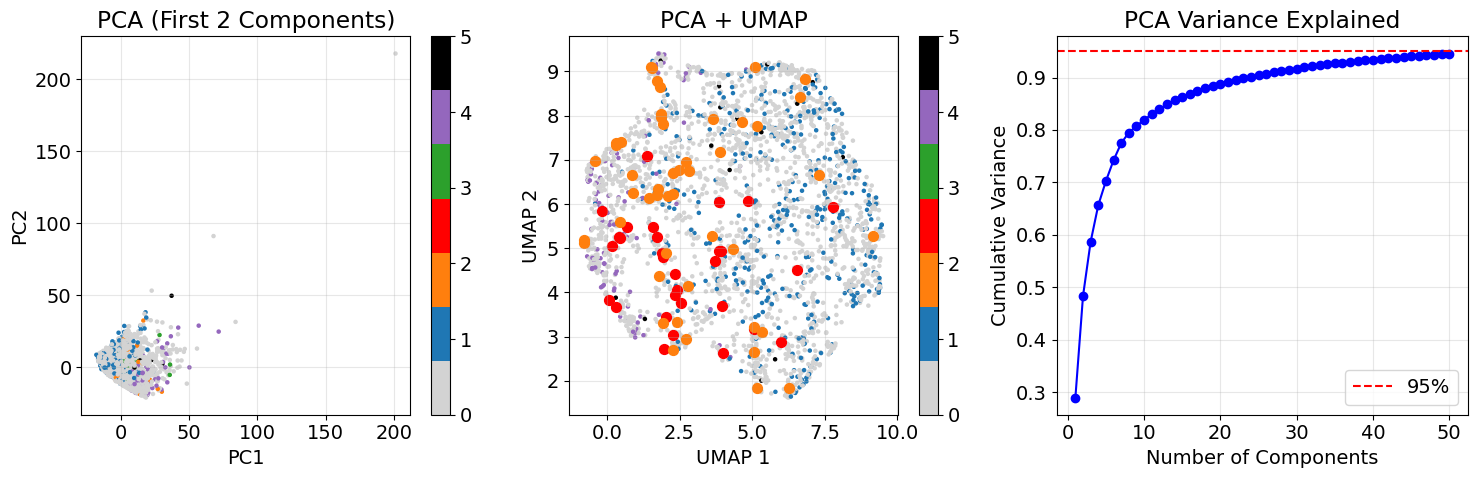

In [17]:
fig = visualize_embeddings_comparison(result, labels=labels)

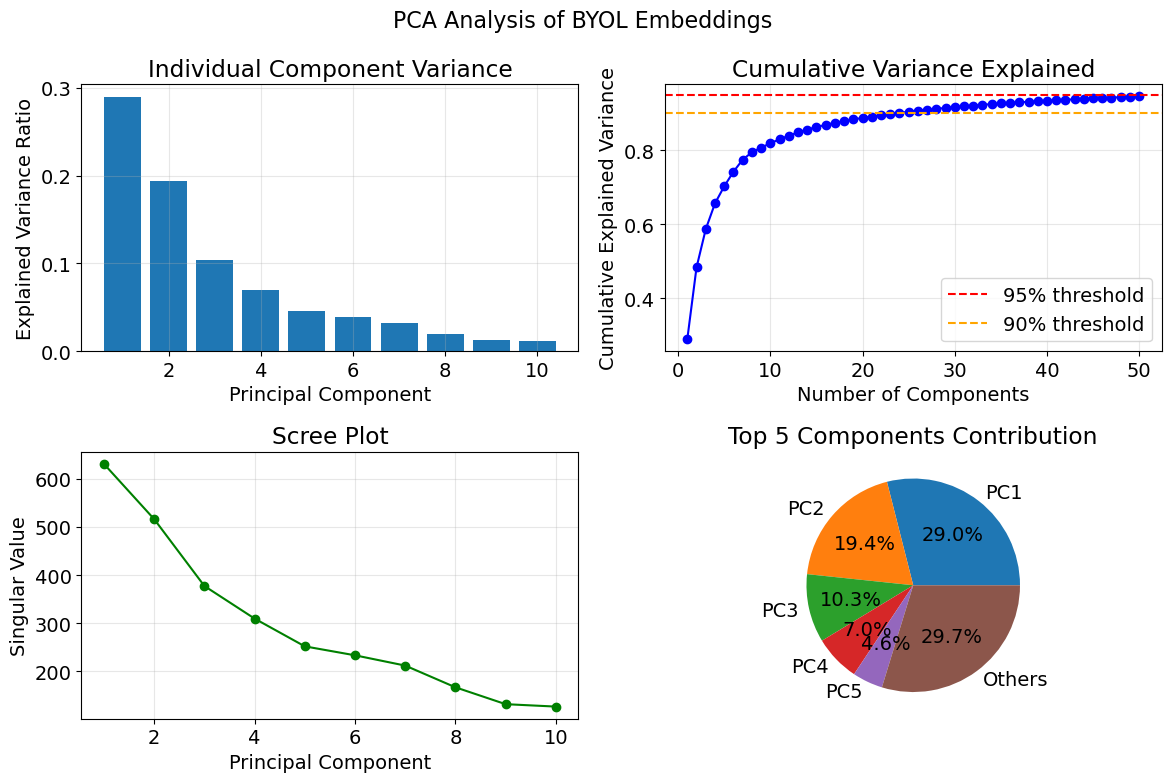

In [18]:
pca_fig = analyze_pca_components(result['pca_info'])
